## Modelling Notebook

This notebook is to be used for testing out the various models that you want to use. No preprocessing will be done in this notebook. 

In [1]:
import sys
sys.path.append('..')
from utils.aux_functions import prepare_features, train_model, predict_unlabeled, plot_feature_importance, plot_logistic_regression_importance, plot_model_metrics, compare_model_predictions, analyze_model_disagreements
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
unlabeled_df = pd.read_csv('../input/unlabeled.csv')

## Step-by-step checklist:

1. Prepare Features
    - Separate features (X) and target (y)

2. Logistic Regression Baseline
    - Train a simple model using logistic regression
    - Evaluate metrics such as accuracy, precision, recall, F1-score and AUC-ROC

3. Random Forest
    - Train a more complex model using Random Forest
    - Use GridSearchCV for hyperparameter tuning
    - Evaluate the same metrics as in step 3

4. Cross-validation
    - Use StratifiedKFold to ensure stability in metrics

5. Visualize results
    - Create visualizations to compare the results of class balancing

5. Final usage
    - Apply the best model and save the results (ID, Possibility of being a Team Rocket member and Predicted Class)

In [2]:
# Preparing features
X_train, y_train, fitted_columns = prepare_features(train_df, is_train=True)
X_test, y_test, _ = prepare_features(test_df, is_train=True)

### Since the target variable is less than 20%, we need to use some techniques to avoid issues.

**If not, the model can just always predict the majority class and get a high accuracy.**

To deal with class inbalance, we can use techniques like:
-  ```class_weight='balanced'``` to give more focues to the minority class.

- Oversampling the minority class with **SMOTE** (Synthetic Minority Over-sampling Technique)

- Undersampling the majority class with **RandomUnderSampler**

- Use metrics that take into account class inbalance, such as **precision**, **recall**, **F1 score** or **AUC-ROC**.

To evaluate which of these techniques best applies to our dataset, let's run a comparison between them:

1. Base
2. With class_weight='balanced'
3. With SMOTE
4. With Undersampling
5. Combination of techniques

For each of these, we wil be comparing

- Accuracy
- Precision
- Recall
- F1 Score
- AUC-ROC

## Logistic Regression


In [3]:
param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000, 5000],
        'class_weight': ['balanced', None]
    }

base_model = LogisticRegression(random_state=42)
    
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
    
grid_search.fit(X_train, y_train)
    
print("\n🎯 Best Parameters:")
print(grid_search.best_params_)
print(f"\n📈 Best ROC-AUC Score: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits

🎯 Best Parameters:
{'C': 10, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

📈 Best ROC-AUC Score: 0.994


In [4]:
lr_model = LogisticRegression(solver="liblinear", max_iter=1000, class_weight= None, penalty="l1", C=10)

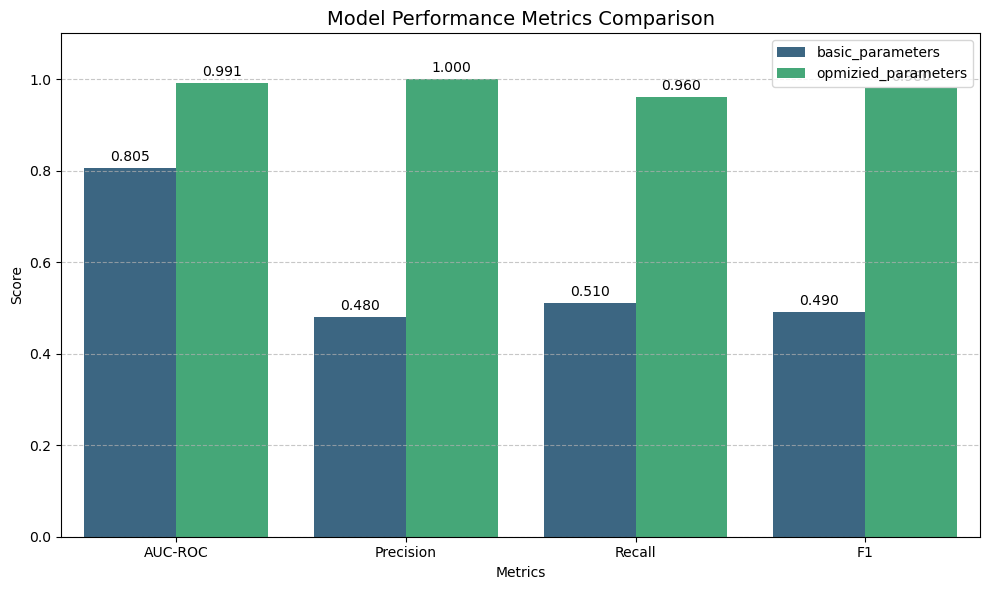

In [5]:
lr_comparison = pd.read_csv('../input/lr_metrics.csv')
plot_model_metrics(lr_comparison)

Fold 1 AUC-ROC: 0.981
Fold 2 AUC-ROC: 0.992
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.985
Fold 5 AUC-ROC: 0.995

Mean CV AUC-ROC: 0.991 (+/- 0.007)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       656
           1       1.00      0.96      0.98       144

    accuracy                           0.99       800
   macro avg       1.00      0.98      0.99       800
weighted avg       0.99      0.99      0.99       800


🧩 Confusion Matrix:
[[656   0]
 [  6 138]]

🎯 Test Set AUC-ROC: 0.982


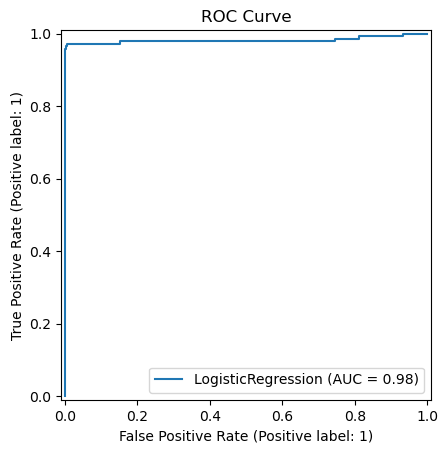

(LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear'),
 0.9907248331123425)

In [6]:
# Base model with no balancing techniques
train_model(lr_model, X_train, X_test, y_train, y_test)

Fold 1 AUC-ROC: 0.981
Fold 2 AUC-ROC: 0.990
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.984
Fold 5 AUC-ROC: 0.993

Mean CV AUC-ROC: 0.990 (+/- 0.007)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       656
           1       0.99      0.96      0.97       144

    accuracy                           0.99       800
   macro avg       0.99      0.98      0.98       800
weighted avg       0.99      0.99      0.99       800


🧩 Confusion Matrix:
[[654   2]
 [  6 138]]

🎯 Test Set AUC-ROC: 0.981


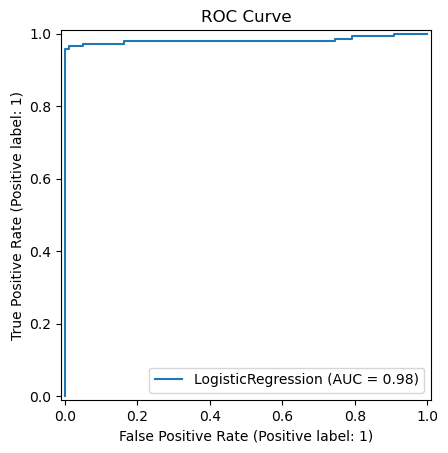

(LogisticRegression(C=10,
                    class_weight={0: 0.6095238095238096, 1: 2.782608695652174},
                    max_iter=1000, penalty='l1', solver='liblinear'),
 0.9896939006505472)

In [7]:
# With class weight
train_model(lr_model, X_train, X_test, y_train, y_test, use_class_weight = True)

Fold 1 AUC-ROC: 0.981
Fold 2 AUC-ROC: 0.992
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.991
Fold 5 AUC-ROC: 0.995

Mean CV AUC-ROC: 0.992 (+/- 0.006)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       656
           1       0.99      0.96      0.97       144

    accuracy                           0.99       800
   macro avg       0.99      0.98      0.98       800
weighted avg       0.99      0.99      0.99       800


🧩 Confusion Matrix:
[[654   2]
 [  6 138]]

🎯 Test Set AUC-ROC: 0.981


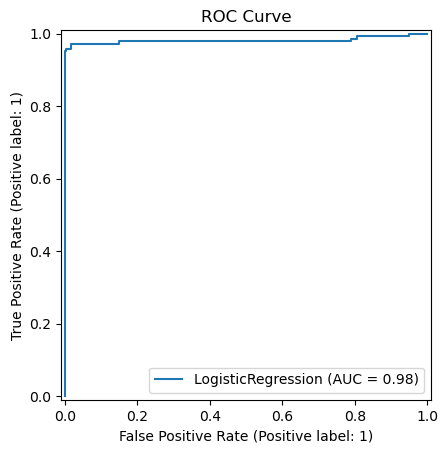

(LogisticRegression(C=10,
                    class_weight={0: 0.6095238095238096, 1: 2.782608695652174},
                    max_iter=1000, penalty='l1', solver='liblinear'),
 0.9916951660483825)

In [8]:
# With SMOTE
train_model(lr_model, X_train, X_test, y_train, y_test, use_smote = True)

Fold 1 AUC-ROC: 0.981
Fold 2 AUC-ROC: 0.992
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.992
Fold 5 AUC-ROC: 0.996

Mean CV AUC-ROC: 0.992 (+/- 0.006)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       656
           1       1.00      0.94      0.97       144

    accuracy                           0.99       800
   macro avg       0.99      0.97      0.98       800
weighted avg       0.99      0.99      0.99       800


🧩 Confusion Matrix:
[[656   0]
 [  8 136]]

🎯 Test Set AUC-ROC: 0.981


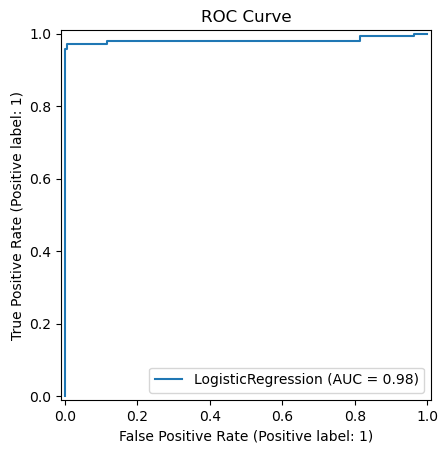

(LogisticRegression(C=10, class_weight={0: 1.0, 1: 1.0}, max_iter=1000,
                    penalty='l1', solver='liblinear'),
 0.9923200716435676)

In [9]:
# With SMOTE and Class Weight
train_model(lr_model, X_train, X_test, y_train, y_test, use_smote = True , use_class_weight=True)

### Now, let's plot feature importance for our model

c:\Users\PC\OneDrive\Documentos\Projetos\pokemon-detective-ml-project\pokemon-detective-ml-project\notebooks\..\utils\aux_functions.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


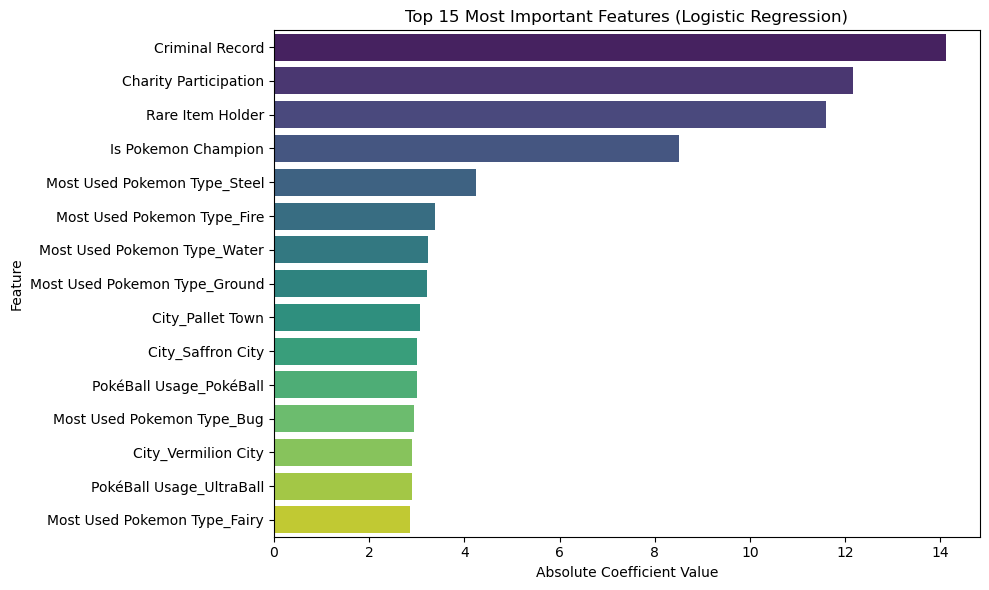


🎯 Top 10 Most Important Features:
                          feature  importance
4                 Criminal Record   14.124923
11          Charity Participation   12.153255
9                Rare Item Holder   11.591277
7             Is Pokemon Champion    8.500513
44   Most Used Pokemon Type_Steel    4.236065
34    Most Used Pokemon Type_Fire    3.389646
45   Most Used Pokemon Type_Water    3.237176
38  Most Used Pokemon Type_Ground    3.213831
64               City_Pallet Town    3.061622
66              City_Saffron City    3.007067

📝 Note: Higher absolute coefficient values indicate stronger influence on predictions.


In [10]:
plot_logistic_regression_importance(lr_model, X_train)

## Random Forest

### Let's try GridSearchCV to test out different hyperparameters for Random Forest

In [11]:
grid = {'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print('Best parameters:', best_params)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


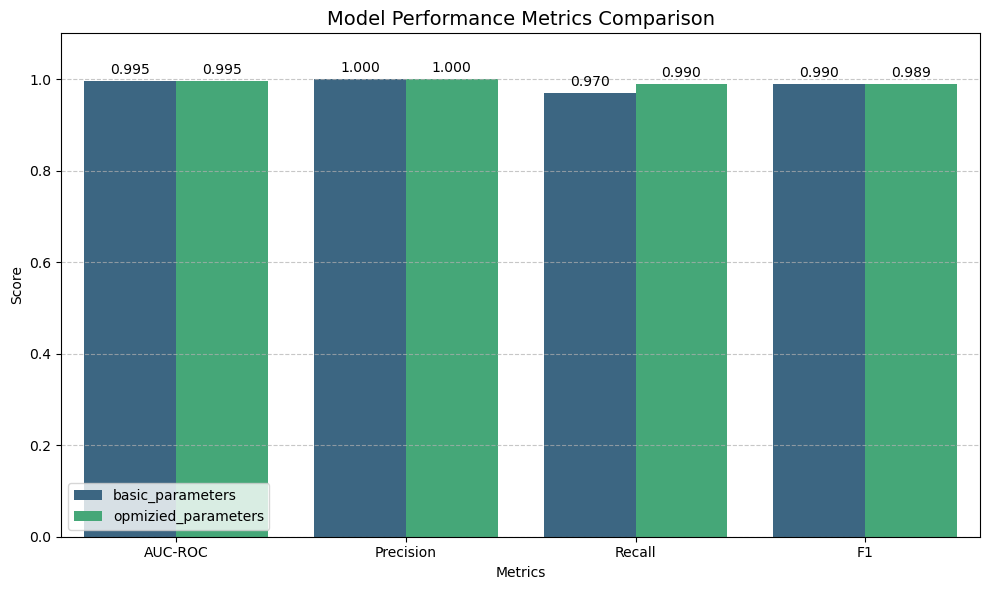

In [12]:
rf_comparison = pd.read_csv('../input/rf_metrics.csv')
plot_model_metrics(rf_comparison)

In [13]:
rf_model = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100)

### Testing different class balancing methods

Fold 1 AUC-ROC: 1.000
Fold 2 AUC-ROC: 0.992
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.993
Fold 5 AUC-ROC: 0.990

Mean CV AUC-ROC: 0.995 (+/- 0.004)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       656
           1       1.00      0.99      0.99       144

    accuracy                           1.00       800
   macro avg       1.00      0.99      1.00       800
weighted avg       1.00      1.00      1.00       800


🧩 Confusion Matrix:
[[656   0]
 [  2 142]]

🎯 Test Set AUC-ROC: 0.997


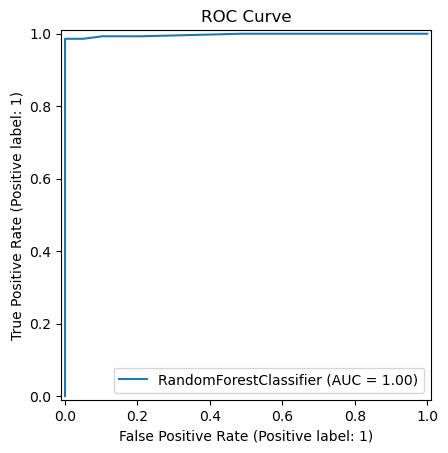

(RandomForestClassifier(bootstrap=False, random_state=42), 0.9949960846185413)

In [14]:
# No balancing
train_model(rf_model, X_train, X_test, y_train, y_test)

Fold 1 AUC-ROC: 1.000
Fold 2 AUC-ROC: 0.994
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.992
Fold 5 AUC-ROC: 0.995

Mean CV AUC-ROC: 0.996 (+/- 0.003)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       656
           1       1.00      0.98      0.99       144

    accuracy                           1.00       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      1.00      1.00       800


🧩 Confusion Matrix:
[[656   0]
 [  3 141]]

🎯 Test Set AUC-ROC: 0.995


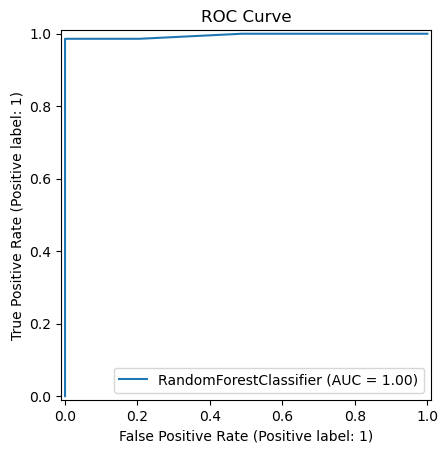

(RandomForestClassifier(bootstrap=False,
                        class_weight={0: 0.6095238095238096,
                                      1: 2.782608695652174},
                        random_state=42),
 0.9962662602722631)

In [15]:
# with class_weight
train_model(rf_model, X_train, X_test, y_train, y_test, use_class_weight=True)

Fold 1 AUC-ROC: 1.000
Fold 2 AUC-ROC: 0.994
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.995
Fold 5 AUC-ROC: 0.994

Mean CV AUC-ROC: 0.997 (+/- 0.003)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       656
           1       1.00      0.97      0.99       144

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800


🧩 Confusion Matrix:
[[656   0]
 [  4 140]]

🎯 Test Set AUC-ROC: 0.995


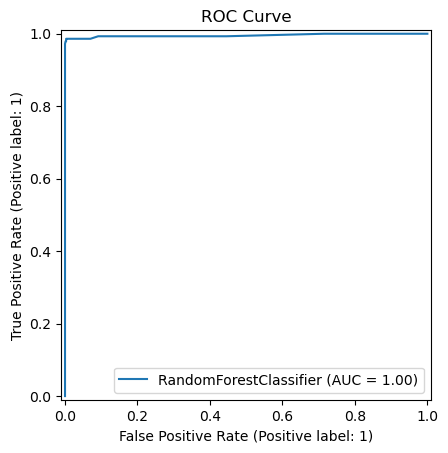

(RandomForestClassifier(bootstrap=False,
                        class_weight={0: 0.6095238095238096,
                                      1: 2.782608695652174},
                        random_state=42),
 0.9966406696869669)

In [16]:
# With SMOTE
train_model(rf_model, X_train, X_test, y_train, y_test, use_smote=True)

Fold 1 AUC-ROC: 1.000
Fold 2 AUC-ROC: 0.992
Fold 3 AUC-ROC: 1.000
Fold 4 AUC-ROC: 0.987
Fold 5 AUC-ROC: 0.993

Mean CV AUC-ROC: 0.994 (+/- 0.005)

📋 Final Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       656
           1       1.00      0.98      0.99       144

    accuracy                           1.00       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      1.00      1.00       800


🧩 Confusion Matrix:
[[656   0]
 [  3 141]]

🎯 Test Set AUC-ROC: 0.998


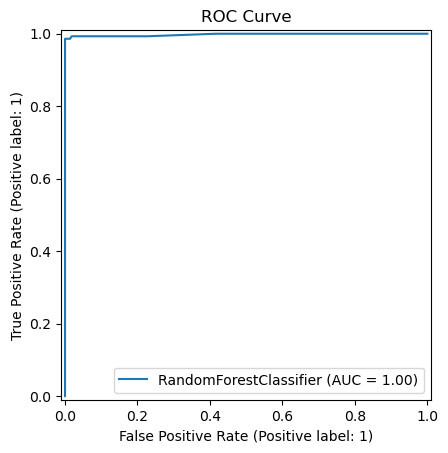

(RandomForestClassifier(bootstrap=False, class_weight={0: 1.0, 1: 1.0},
                        random_state=42),
 0.9944024801394287)

In [17]:
# With SMOTE and class_weight
train_model(rf_model, X_train, X_test, y_train, y_test, use_smote=True, use_class_weight=True)

### Key takeaways:
- Random Forest delivers **exceptional performance** even without balancing (**1.0** precision, **0.97** recall, **0.990** AUC-ROC)
- Class weighting and SMOTE do not significantly improve performance, the base model is already very strong.
- Random Forest is great at dealing with class inbalance


### Ranking feature importance

c:\Users\PC\OneDrive\Documentos\Projetos\pokemon-detective-ml-project\pokemon-detective-ml-project\notebooks\..\utils\aux_functions.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


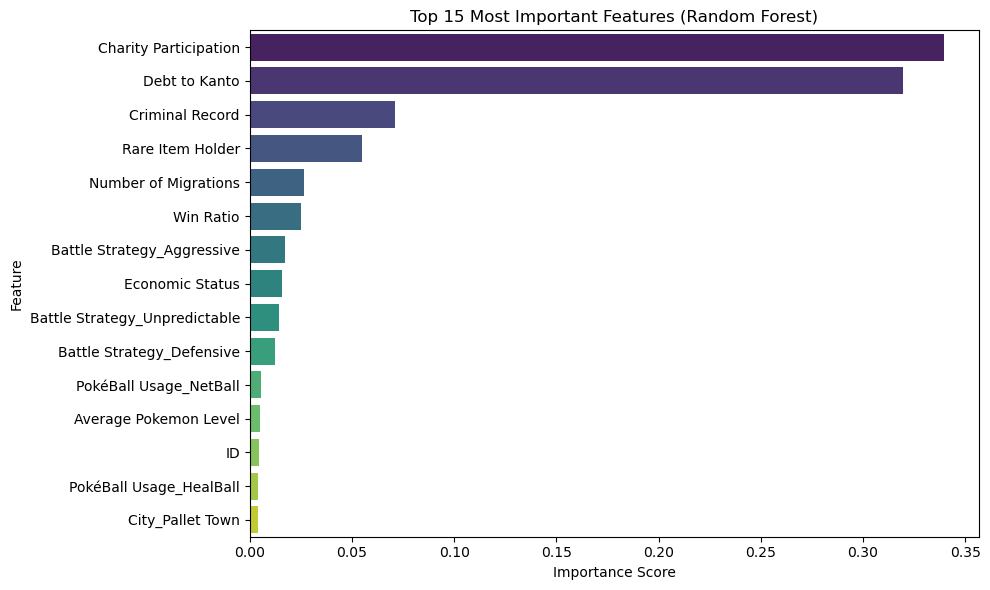


🎯 Top 10 Most Important Features:
                          feature  importance
11          Charity Participation    0.339769
10                  Debt to Kanto    0.319612
4                 Criminal Record    0.071113
9                Rare Item Holder    0.055043
8            Number of Migrations    0.026408
5                       Win Ratio    0.024952
56     Battle Strategy_Aggressive    0.017311
2                 Economic Status    0.015988
58  Battle Strategy_Unpredictable    0.014305
57      Battle Strategy_Defensive    0.012315

📝 Note: Higher importance scores indicate stronger influence on predictions.


In [18]:
plot_feature_importance(rf_model, X_train)

## Generating the predictions

In [19]:
# predict_unlabeled(lr_model, unlabeled_df, fitted_columns, output_path='../output')
# predict_unlabeled(rf_model, unlabeled_df, fitted_columns, output_path='../output')

## Finally, let's compare the results from both predictions

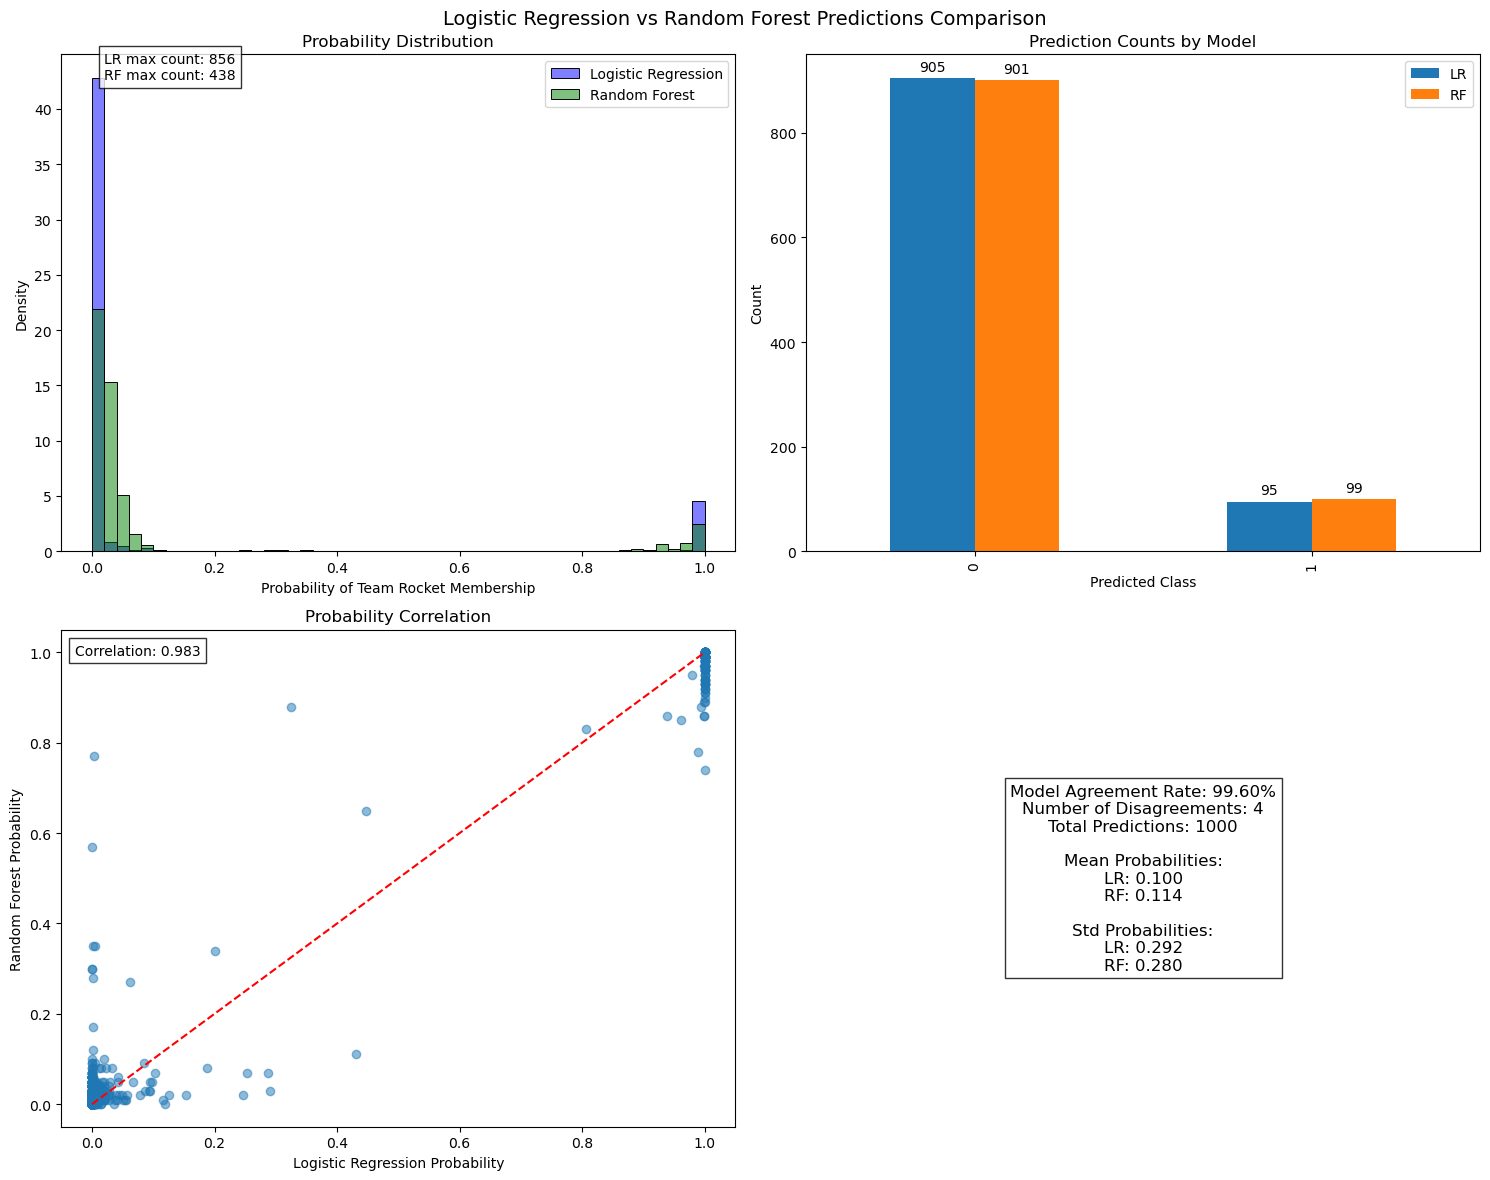

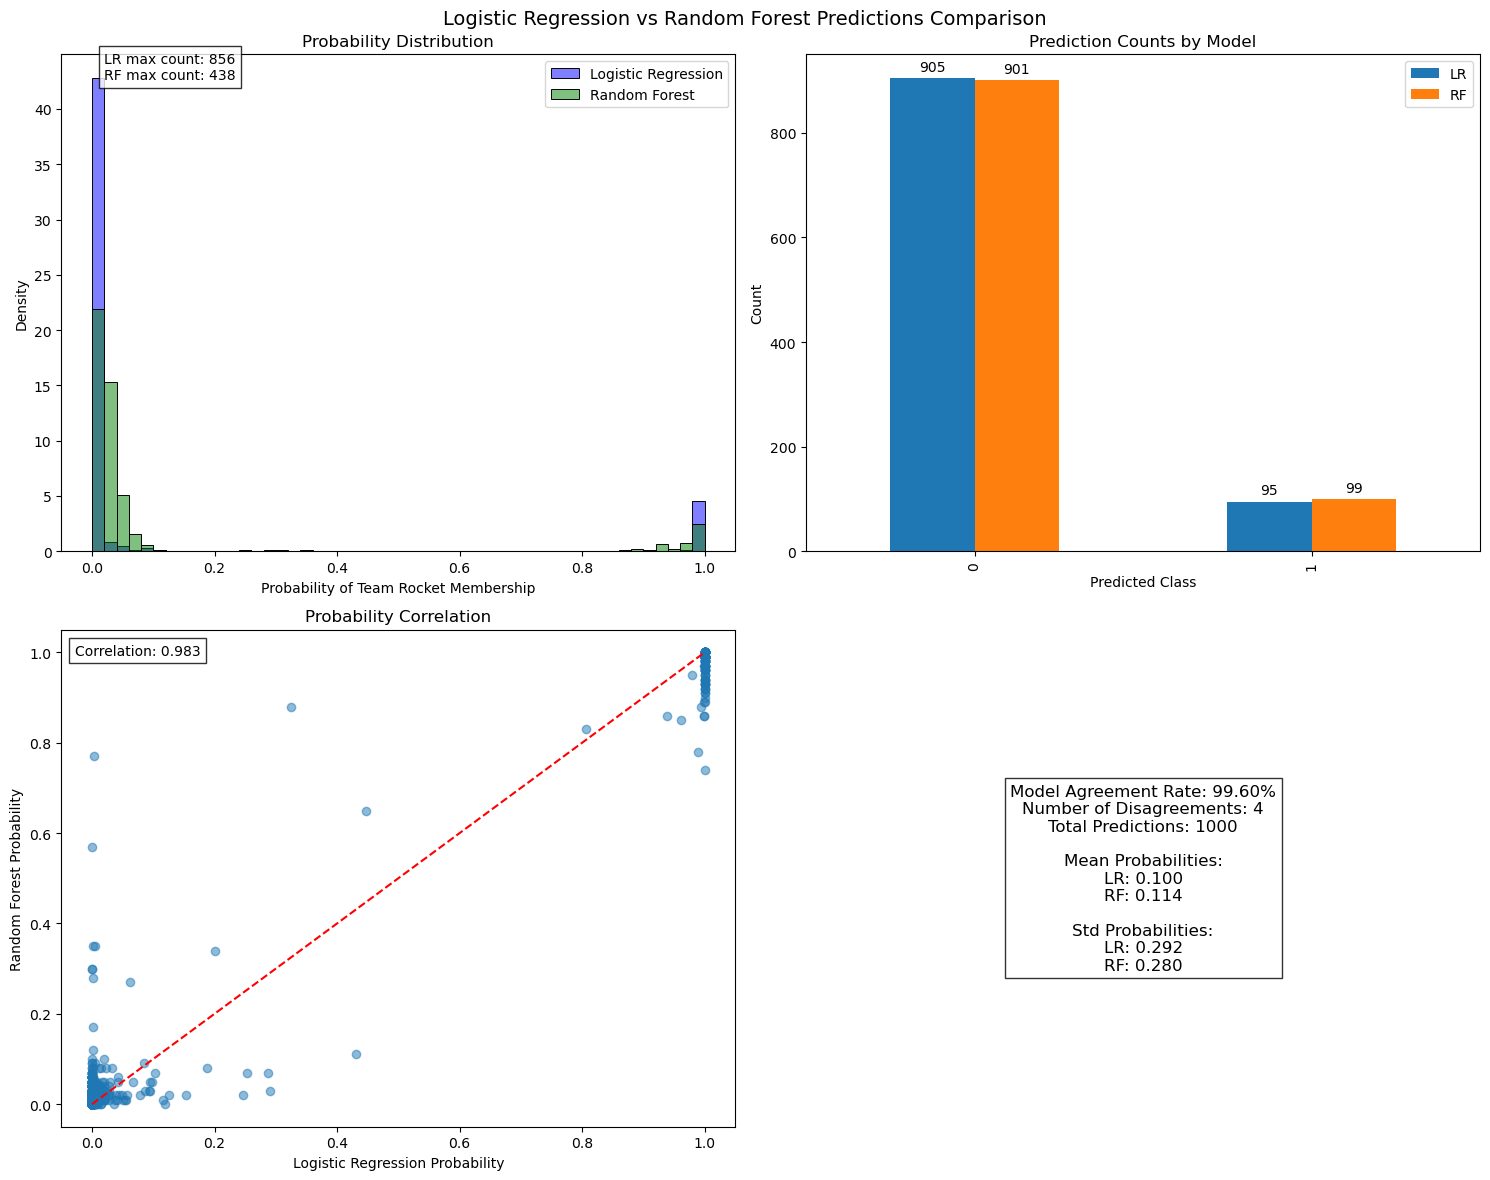

In [20]:
lr_predictions = pd.read_csv('../output/predictions_lr.csv')
rf_predictions = pd.read_csv('../output/predictions_rf.csv')
compare_model_predictions(lr_predictions, rf_predictions)

### Let's analyze these four unique citizens that are the reason of disagreement from our models

In [21]:
analyze_model_disagreements(lr_predictions, rf_predictions)

,ID,Age,City,Economic Status,Profession,Most Used Pokemon Type,Average Pokemon Level,Criminal Record,PokéBall Usage,Win Ratio,Number of Gym Badges,Battle Strategy,Number of Migrations,Rare Item Holder,Debt to Kanto,Charity Participation,Team_Rocket_Probability,Team_Rocket_Prediction,RF_Probability,RF_Prediction
256,4256,58,Fuchsia City,0.0,Police Officer,Poison,51,0,MasterBall,61,4,Aggressive,4,0,155543,1,0.002399,0,0.77,1
268,4268,24,Lavender Town,1.0,Casino Worker,Electric,95,0,NetBall,67,0,Defensive,29,0,43200,1,0.000117,0,0.57,1
339,4339,60,Vermilion City,1.0,Researcher,Grass,17,0,DuskBall,70,1,Defensive,6,0,28316,0,0.325173,0,0.88,1
932,4932,25,Pallet Town,0.0,Underground Battler,Rock,73,0,NetBall,31,4,Aggressive,23,0,144459,1,0.447303,0,0.65,1
